In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import h3

import json
import time
import datetime

**1 -- home detection based on h3 hexagons**

In [2]:
# parameters
h3_resolution = 10
minimum_checkins = 10

In [3]:
# check-in data
cdf = pd.read_csv("../data/Gowalla_totalCheckins.txt", sep="\t", header=None)
cdf.columns = ["user", "checkin_time", "lat", "lon", "location_id"]

In [4]:
# create an hour column
cdf["checkin_time"] = pd.to_datetime(cdf["checkin_time"])
cdf["hour"] = cdf["checkin_time"].dt.hour

In [42]:
def coords_to_point(lat, lon):
    """create Point geometry from lat, lon columns"""
    geometry = [Point(xy) for xy in zip(lon, lat)]
    return geometry

def point_geometry_to_h3(geodf, geometry_col, h3_resolution):
    """h3 from Point geometry"""
    h3_col = geodf.apply(lambda r: h3.geo_to_h3(r[geometry_col].y, r[geometry_col].x, h3_resolution), axis=1)
    return h3_col


In [6]:
# filter cdf by input parameters
cdf["nr_locations"] = cdf.groupby(["user"])["location_id"].transform("nunique")
lcdf = cdf[cdf["nr_locations"] >= minimum_checkins]

In [7]:
# construct h3 codes
start_time = time.time()
lcdf["point_geom"] = coords_to_point(lcdf["lat"], lcdf["lon"])
lcdf["h3"] = point_geometry_to_h3(lcdf, geometry_col="point_geom", h3_resolution=h3_resolution)
print("--- %s seconds ---" % round((time.time() - start_time), 3))

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_30853/3823937718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdf["point_geom"] = coords_to_point(lcdf["lat"], lcdf["lon"])


--- 83.141 seconds ---


/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_30853/3823937718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdf["h3"] = point_geometry_to_h3(lcdf, geometry_col="point_geom", h3_resolution=h3_resolution)


In [8]:
# select the most visited h3 by user
def home_table(df, min_locations_in_h3, min_visits_in_h3):
    """function to select home h3 of users"""
    
    # variables to support selection
    h3_selection = df.groupby(["user", "h3"]).agg(
        locations_in_h3 = pd.NamedAgg("location_id", "nunique"),
        visits_in_h3 = pd.NamedAgg("location_id", "count")
        ).reset_index()

    h3_selection["max_locations_in_h3"] = h3_selection.groupby(["user"])["locations_in_h3"].transform("max")
    h3_selection["max_visits_in_h3"] = h3_selection.groupby(["user"])["visits_in_h3"].transform("max")

    # filter
    h3_selection = h3_selection[
        (h3_selection["visits_in_h3"] == h3_selection["max_visits_in_h3"]) &
        (h3_selection["max_locations_in_h3"] >= min_locations_in_h3) &
        (h3_selection["max_visits_in_h3"] >= min_visits_in_h3)
    ]
    
    return h3_selection

In [17]:
# no home hours focus
home_df = home_table(lcdf, min_locations_in_h3=1, min_visits_in_h3=5)

# export
home_df.to_csv("../outputs/home_location.csv", sep=";", index=False)

In [18]:
# filter for checkins in home hours -- same as for the twitter data
hh_lcdf = lcdf[
    (lcdf["hour"] >= 20) |
    (lcdf["hour"] <= 7)
]

home_df2 = home_table(hh_lcdf, min_locations_in_h3=1, min_visits_in_h3=5)

# export
home_df2.to_csv("../outputs/home_location_home_hours.csv", sep=";", index=False)

**add home locations to edgelist**

In [105]:
# edgelist
edf = pd.read_csv("../data/Gowalla_edges.txt", sep="\t")
edf.columns = ["user1", "user2"]

# home options
home_df = pd.read_csv("../outputs/home_location.csv", sep=";")
#home_df = pd.read_csv("../outputs/home_location_home_hours.csv", sep=";")

In [106]:
# census tract geoms
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/shape_files/censustract_geoms_top50.geojson').readlines()]
)
tract_geoms = tract_geoms.set_crs("epsg:4326")

In [107]:
# h3 hex boundary - polygon - centroid
def h3_geometries(df, h3_column):
    """dataframe with h3 hex to geodataframe with polygon and centroid"""

    df["geometry"] = df[h3_column]\
        .apply(lambda x: h3.h3_to_geo_boundary(h=x, geo_json=True))

    df["geometry"] = df["geometry"]\
        .apply(lambda x: [Point(x, y) for [x, y] in x])

    df["geometry"] = df["geometry"]\
        .apply(lambda x: Polygon([[poly.x, poly.y] for poly in x]))

    df = gpd.GeoDataFrame(df, geometry="geometry")
    
    df["centroid_lat"] = df["geometry"].centroid.y
    df["centroid_lon"] = df["geometry"].centroid.x
    
    return df

In [108]:
home_df = h3_geometries(home_df, h3_column="h3")

In [109]:
# function defined in part 1 -- function .py -- WIP
home_df["home_geom"] = coords_to_point(home_df["centroid_lat"], home_df["centroid_lon"])
home_df = gpd.GeoDataFrame(home_df, geometry="home_geom", crs="EPSG:4326")


In [110]:
def locations_to_census_tracts(points, tracts):
    """spatial join locations to census tracts"""
    location_with_tract = gpd.sjoin(
        points,
        tracts,
        "left",
        "within",
    )
    return location_with_tract

In [111]:
home_df = locations_to_census_tracts(home_df, tract_geoms)
home_df.dropna(subset=["full_geoid"], inplace=True)

In [112]:
# add cbsacode
cbsa = pd.read_csv("../data/cbsacode_shortname_tracts.csv", sep=";", index_col=0)

home_df = pd.merge(
    home_df,
    cbsa,
    left_on="full_geoid",
    right_on="geoid",
    how="left"
)

In [113]:
# nodelist with key columns ONLY
nodelist = home_df[["user", "h3", "centroid_lat", "centroid_lon", "geoid", "cbsacode", "short_name"]]

# export
nodelist.to_csv("../outputs/gowalla_nodelist.csv", sep=";", index=False)
#nodelist.to_csv("../outputs/gowalla_nodelist_home_hours.csv", sep=";", index=False)


In [115]:
# add the coordinates to the edgelist
edf = pd.merge(
    edf,
    nodelist,
    left_on="user1",
    right_on="user",
    how="left"
)
edf = pd.merge(
    edf,
    nodelist,
    left_on="user2",
    right_on="user",
    how="left",
    suffixes=["1","2"]
)

# remove duplicate columns
edf = edf.loc[:,~edf.columns.duplicated()].copy()

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_31157/3570803636.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'user1'} in the result is deprecated and will raise a MergeError in a future version.
  edf = pd.merge(


In [116]:
# clean up
edf = edf.dropna(subset=["geoid1", "geoid2"])

# keep inner city ties ONLY
print(edf.shape)
el = edf[edf["short_name1"] == edf["short_name2"]]
print(el.shape)

(139188, 14)
(66048, 14)


In [117]:
# export
el.to_csv("../outputs/gowalla_edgelist.csv", sep=";", index=False)
#el.to_csv("../outputs/gowalla_edgelist_home_hours.csv", sep=";", index=False)

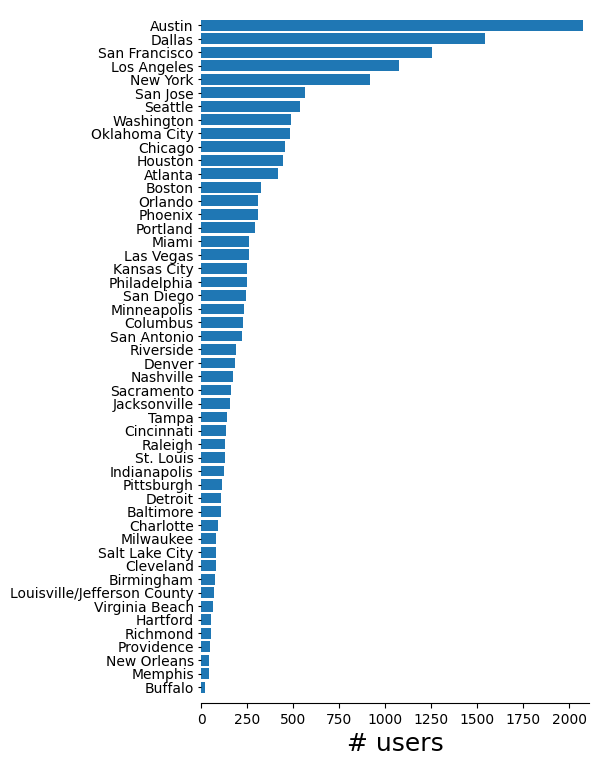

In [118]:
# plot the number of inventors -- connected locations..
def gowalla_users_per_metro_plot(nodelist, ax=None):
    pdata = nodelist.groupby(["short_name"])["user"].agg("nunique").reset_index().sort_values(by="user")

    if ax is None:
        ax = plt.gca()
    ax.barh(pdata["short_name"], pdata["user"])  
    ax.margins(0.015, tight=True)
    ax.set_xlabel("# users", size=18)
    ax.tick_params("y", size=2, labelsize=10)
    ax.tick_params("x", labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(5, 9))
gowalla_users_per_metro_plot(nodelist, ax=ax)

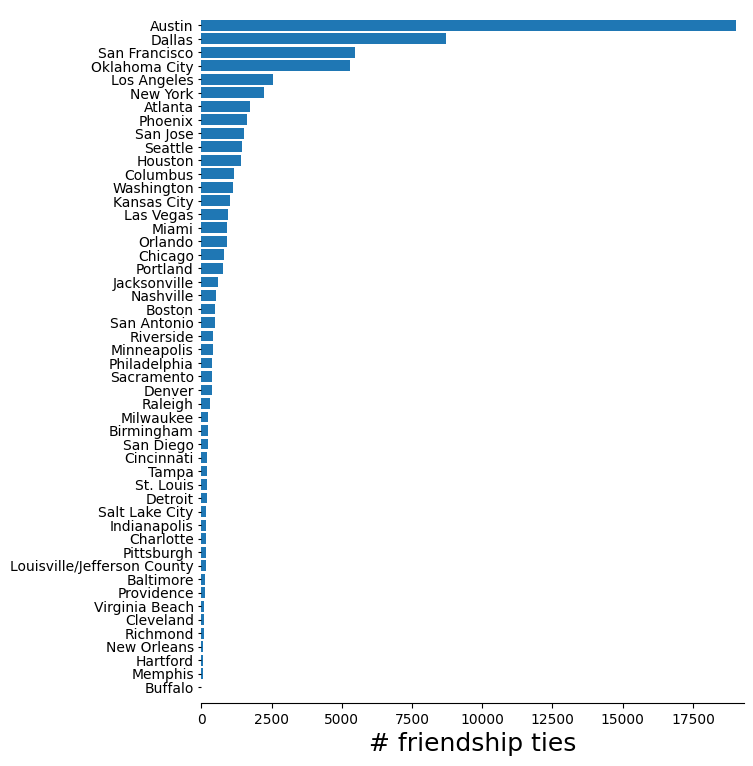

In [119]:
# plot the number of edges inside metros
def edges_inside_metros(el, ax=None):
    pdata = el.groupby(["short_name1"])["user1"].agg("count").reset_index().sort_values(by="user1")

    if ax is None:
        ax = plt.gca()
    ax.barh(pdata["short_name1"], pdata["user1"])  
    ax.margins(0.015, tight=True)
    ax.set_xlabel("# friendship ties", size=18)
    ax.tick_params("y", size=2, labelsize=10)
    ax.tick_params("x", labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(7, 9))
edges_inside_metros(el, ax=ax)